# Metal Sheet Classifier
**Purpose:** Create an application which classifies defects in metal sheets that arise during manufacturing, identifies defect location and size on those sheets, and measures defect change over time.
<br>**Method:** To achieve these goals I will do the follow:

1. **Sample Generation:** Since I lack access to a sufficient dataset of images, I will create a series of sample data.
2. **Model Design and Training:** I will then design and train two neural net models, one for defect classification (what kind of defect is on the sheet), and one for defect location and size.
3. **Change Analysis:** I will use the models thus developed to identify the average rate of change for each defect (i.e, the speed at which the defect spreads across the surface area of the sheet). With more information on the process (such as what conditions are tracked during manufacturing) it would be trivial to extend the analysis to investigate what conditions are most likely to lead to certain defects, or a high rate of defect.

I created two defect classes, Lines and Bubbles


Text(0.5, 1.0, 'None')

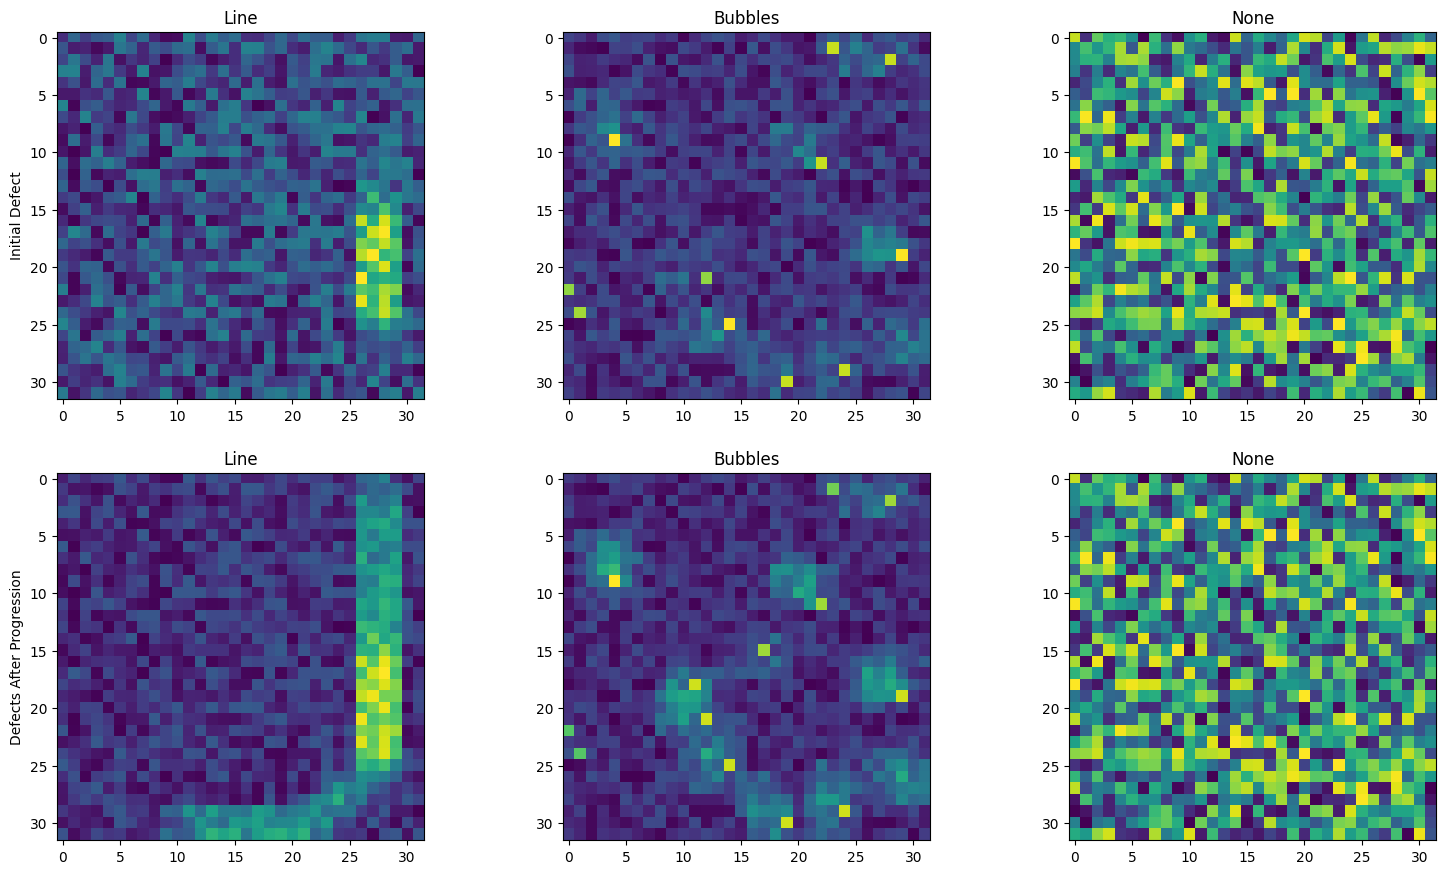

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from defects.Defect import Defect
from defects.Line import Line
from defects.Bubbles import Bubbles

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

print('I created two defect classes, Lines and Bubbles')
fig, axs = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5)
axs.flat[0].set(ylabel='Initial Defect')
axs.flat[3].set(ylabel='Defects After Progression')
l = Line(divergence_odds=10, growth_odds=70, growth_factor=1, initial_growth=2, id=0); l.show(axe=axs[0,0])
axs[0,0].set_title('Line')
b = Bubbles(0, initial_growth=2); b.show(axe=axs[0,1])
axs[0,1].set_title('Bubbles')
d = Defect(0); d.show(axe=axs[0,2])
axs[0,2].set_title('None')

l.advance(60); l.show(axe=axs[1,0])
axs[1,0].set_title('Line')
b.advance(60); b.show(axe=axs[1,1])
axs[1,1].set_title('Bubbles')
d.advance(); d.show(axe=axs[1,2])
axs[1,2].set_title('None')

# b = Bubbles(0); b.show()
# f2.title.set_text('Bubbles')
# f2 = plt.subplot(1,3,3)
# d = Defect(0); d.show()
# f2.title.set_text('None')

# f3 = plt.subplot(1,3,1)
# f3.title.set_text('Line')
# l.advance(30); l.show()
# f4 = plt.subplot(1,3,2)
# b.advance(30); b.show()
# f4.title.set_text('Bubbles')
# f5 = plt.subplot(1,3,3)
# d = Defect(0).show()
# f5.title.set_text('None')



# Load Trained Models


In [4]:
from models.SheetClassifier import SheetClassifier
from models.SheetHighlighter import SheetHighlighter
from datasets.ClassificationSet import ClassificationSet
sheet_data_dir = './sheet_data'

s_classifier, s_highlighter = SheetClassifier(), SheetHighlighter()
s_classifier.eval(); s_highlighter.eval()
s_classifier.load_state_dict(torch.load('./classifier_model.pkl', weights_only = True))
s_highlighter.load_state_dict(torch.load('./highlighter_model.pkl', weights_only = True))
cs = ClassificationSet(sheet_data_dir+'/timelapse')

# Classify and Average Coverage

In [29]:
meta = pd.read_csv(sheet_data_dir+'/timelapse/metadata.csv')
grouped = meta.groupby('id')

deltas = {'1':[],'2':[]}

# Groups timelapse data by id
for g in grouped:
    df = g[1]

    # Load one of the arrs and classify the defect with it
    arr = cs.run_transform(df.img_filename.iloc[-5])
    defect_class = s_classifier(arr.unsqueeze(0))
    defect_class = str(torch.argmax(defect_class,dim=1)[0].detach().numpy())
    if defect_class == '0': continue
    
    for i in range(len(df.img_filename)):
        arr = cs.run_transform(df.img_filename.iloc[i])
        highlight = s_highlighter(arr.unsqueeze(0))
        highlight = highlight.detach().numpy()[0][0]
        highlight[highlight < .05] = 0
        highlight[highlight > .05] = 1
        coverage = highlight.sum()/(highlight.size)
        if len(deltas[defect_class]) <= i: deltas[defect_class].append(coverage)
        else: deltas[defect_class][i] = (deltas[defect_class][i] + coverage)/2

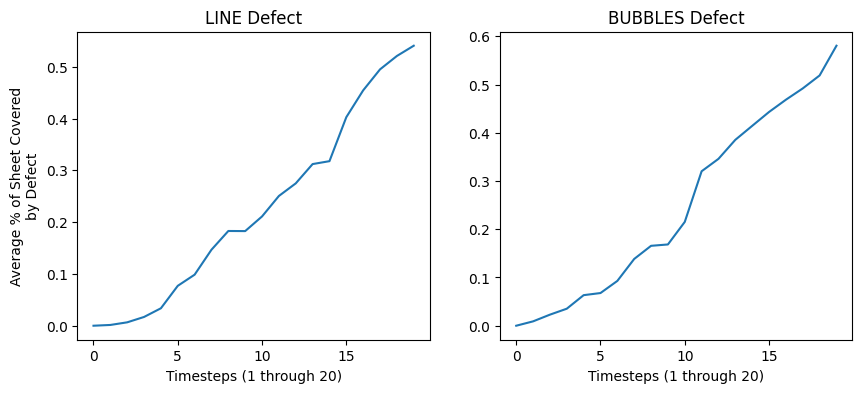

In [30]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(10,4)
axes[0].set_title('LINE Defect')
axes[1].set_title('BUBBLES Defect')
axes.flat[0].set(ylabel='Average % of Sheet Covered\nby Defect',xlabel='Timesteps (1 through 20)')
axes.flat[1].set(xlabel='Timesteps (1 through 20)')
axes[0].plot(np.arange(0,len(deltas['1'])),np.array(deltas['1']))
axes[1].plot(np.arange(0,len(deltas['2'])),np.array(deltas['2']))

# Conclusion
Thus we've ascertained workable data for analysis. I want to stress that this was very much a "toy" project, meant to demonstrate my understanding and proficiency. There are a number of areas that I would shore up (adding logging, regularization, etc.) if this were to become an actual project. Further this data would only useful in conjunction with other data points (what temperature a metal sheet was smelted at, whether there was anything different about it's composition). However, I hope that it serves it's aforementioned purpose.